In [1]:
from lmmNet import lmmNet

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt

# 1. Create training data

Here we test the problem on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$.

In [2]:
def f(x,t):
    """
    Return the derivatives (RHS of the ODE)
    This is a linear system with the form f = A x
    Args:
    x -- a 2 x 1 vector of measurements
    """
    A = np.array([[-0.1, 2], [-2,-0.1]]) # 2 x 2

    return np.ravel(np.matmul(A,x.reshape(-1, 1)**3))

Now we are ready to create the training dataset by integrating the above system of equations to obtain the measurements. We also introduce a Gaussian noise to the dataset.

**Update**.
1. We consider only time from 0 to 1.
2. We are also going to vary the mesh size to examine the stability behaviour.

In [6]:
# create time points
#time_points = np.arange(0, 25, 0.01)
time_points = np.arange(0, 1, 0.01) # 100 grid points

# specify initial conditions
x0 = np.array([2,0])

simulated_x = odeint(f, x0, time_points)

In [7]:
# create training data

noise = 0.00 #strength of the noise

skip = 1
dt = time_points[skip] - time_points[0]
X_train = simulated_x[0::skip,:]
X_train = X_train + noise * X_train.std(0) * np.random.randn(X_train.shape[0], X_train.shape[1])

X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))

This notebook was developed with LMMNet v1.1. From preliminary experiments, it seems that 10,000 epochs are sufficient to get a loss that more or less converges.

In [8]:
X_train.shape

(1, 100, 2)

In [9]:
def ml_f(x):
    """
    Define the derivatives (RHS of the ODE) learned by ML
    I think this is the best implementation (more robust than flatten())
    """
    return np.ravel(model.predict(x.reshape(1,-1)))
    
#predicted_traj = odeint(lambda x, t: ml_f(x), x0, time_points)

# 2. Verification of results

Here we verify our results against Figure 3 of [Keller & Du, 2020](https://arxiv.org/abs/1912.12728). Note that the grid size can be used to deduce the time step size.

In [10]:
# right now the layers are hardcoded.
schemes = ['AB', 'BDF', 'AM']
N_Iter = 10000
errors = {} #store L1-norm of MAE at every grid point

for M in [1, 2, 3, 4, 5]:
    for scheme in schemes:
        model = lmmNet(dt, X_train, M, scheme)
        model.train(N_Iter)
    
        errors[scheme + str(M)] = [np.sum(abs(ml_f(y) - f(y, None))) for y in X_train[0,:,:]]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Loss: 1.091e-02, Time: 0.23
Epoch: 100, Loss: 1.442e-03, Time: 6.17
Epoch: 200, Loss: 7.865e-04, Time: 11.52
Epoch: 300, Loss: 7.677e-04, Time: 17.37
Epoch: 400, Loss: 7.444e-04, Time: 22.71
Epoch: 500, Loss: 7.148e-04, Time: 27.60
Epoch: 600, Loss: 6.767e-04, Time: 32.65
Epoch: 700, Loss: 6.277e-04, Time: 37.80
Epoch: 800, Loss: 5.665e-04, Time: 42.91
Epoch: 900, Loss: 4.922e-04, Time: 48.10
Epoch: 1000, Loss: 4.060e-04, Time: 53.33
Epoch: 1100, Loss: 3.154e-04, Time: 58.18
Epoch: 1200, Loss:

Epoch: 5900, Loss: 1.566e-07, Time: 358.55
Epoch: 6000, Loss: 1.430e-07, Time: 364.24
Epoch: 6100, Loss: 1.307e-07, Time: 369.26
Epoch: 6200, Loss: 1.195e-07, Time: 374.23
Epoch: 6300, Loss: 1.093e-07, Time: 380.42
Epoch: 6400, Loss: 1.002e-07, Time: 387.37
Epoch: 6500, Loss: 9.197e-08, Time: 392.82
Epoch: 6600, Loss: 8.459e-08, Time: 398.42
Epoch: 6700, Loss: 7.800e-08, Time: 403.69
Epoch: 6800, Loss: 7.212e-08, Time: 409.30
Epoch: 6900, Loss: 6.689e-08, Time: 414.74
Epoch: 7000, Loss: 6.225e-08, Time: 419.34
Epoch: 7100, Loss: 5.811e-08, Time: 423.94
Epoch: 7200, Loss: 5.444e-08, Time: 429.09
Epoch: 7300, Loss: 5.116e-08, Time: 433.94
Epoch: 7400, Loss: 4.824e-08, Time: 440.93
Epoch: 7500, Loss: 4.562e-08, Time: 447.49
Epoch: 7600, Loss: 4.325e-08, Time: 452.75
Epoch: 7700, Loss: 4.111e-08, Time: 457.20
Epoch: 7800, Loss: 3.915e-08, Time: 462.20
Epoch: 7900, Loss: 3.736e-08, Time: 466.41
Epoch: 8000, Loss: 3.571e-08, Time: 470.62
Epoch: 8100, Loss: 3.416e-08, Time: 475.74
Epoch: 8200

Epoch: 1800, Loss: 3.754e-05, Time: 104.67
Epoch: 1900, Loss: 2.609e-05, Time: 110.25
Epoch: 2000, Loss: 1.871e-05, Time: 116.50
Epoch: 2100, Loss: 1.396e-05, Time: 122.12
Epoch: 2200, Loss: 1.081e-05, Time: 127.66
Epoch: 2300, Loss: 8.641e-06, Time: 133.73
Epoch: 2400, Loss: 7.065e-06, Time: 139.27
Epoch: 2500, Loss: 5.877e-06, Time: 144.85
Epoch: 2600, Loss: 4.952e-06, Time: 151.25
Epoch: 2700, Loss: 4.213e-06, Time: 156.86
Epoch: 2800, Loss: 3.610e-06, Time: 162.46
Epoch: 2900, Loss: 3.105e-06, Time: 168.82
Epoch: 3000, Loss: 2.673e-06, Time: 174.43
Epoch: 3100, Loss: 2.298e-06, Time: 180.59
Epoch: 3200, Loss: 1.968e-06, Time: 186.21
Epoch: 3300, Loss: 1.675e-06, Time: 191.76
Epoch: 3400, Loss: 1.417e-06, Time: 198.02
Epoch: 3500, Loss: 1.190e-06, Time: 203.57
Epoch: 3600, Loss: 9.934e-07, Time: 209.11
Epoch: 3700, Loss: 8.245e-07, Time: 215.19
Epoch: 3800, Loss: 6.808e-07, Time: 220.73
Epoch: 3900, Loss: 5.598e-07, Time: 226.32
Epoch: 4000, Loss: 4.592e-07, Time: 232.60
Epoch: 4100

Epoch: 9300, Loss: 1.106e-08, Time: 538.16
Epoch: 9400, Loss: 1.081e-08, Time: 543.84
Epoch: 9500, Loss: 1.057e-08, Time: 550.16
Epoch: 9600, Loss: 1.034e-08, Time: 555.73
Epoch: 9700, Loss: 1.010e-08, Time: 561.91
Epoch: 9800, Loss: 9.873e-09, Time: 567.47
Epoch: 9900, Loss: 9.646e-09, Time: 573.03

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Loss: 1.060e-02, Time: 0.10
Epoch: 100, Loss: 1.375e-03, Time: 5.67
Epoch: 200, Loss: 7.865e-04, Time: 11.29
Epoch: 300, Loss: 7.669e-04, Time: 17.45
Epoch: 400, Loss: 7.417e-04, Time: 23.00
Epoch:

Epoch: 5200, Loss: 2.472e-07, Time: 417.08
Epoch: 5300, Loss: 2.307e-07, Time: 429.42
Epoch: 5400, Loss: 2.157e-07, Time: 439.63
Epoch: 5500, Loss: 2.019e-07, Time: 452.74
Epoch: 5600, Loss: 1.892e-07, Time: 461.30
Epoch: 5700, Loss: 1.776e-07, Time: 468.91
Epoch: 5800, Loss: 1.668e-07, Time: 476.44
Epoch: 5900, Loss: 1.570e-07, Time: 483.93
Epoch: 6000, Loss: 1.478e-07, Time: 492.86
Epoch: 6100, Loss: 1.394e-07, Time: 501.14
Epoch: 6200, Loss: 1.315e-07, Time: 508.69
Epoch: 6300, Loss: 1.242e-07, Time: 516.19
Epoch: 6400, Loss: 1.173e-07, Time: 523.70
Epoch: 6500, Loss: 1.108e-07, Time: 531.35
Epoch: 6600, Loss: 1.046e-07, Time: 538.94
Epoch: 6700, Loss: 9.873e-08, Time: 546.65
Epoch: 6800, Loss: 9.311e-08, Time: 554.18
Epoch: 6900, Loss: 8.773e-08, Time: 561.67
Epoch: 7000, Loss: 8.257e-08, Time: 569.19
Epoch: 7100, Loss: 7.762e-08, Time: 576.73
Epoch: 7200, Loss: 7.287e-08, Time: 584.31
Epoch: 7300, Loss: 6.831e-08, Time: 592.63
Epoch: 7400, Loss: 6.394e-08, Time: 600.74
Epoch: 7500

Epoch: 1100, Loss: 3.408e-04, Time: 83.60
Epoch: 1200, Loss: 2.466e-04, Time: 91.12
Epoch: 1300, Loss: 1.790e-04, Time: 98.67
Epoch: 1400, Loss: 1.337e-04, Time: 106.26
Epoch: 1500, Loss: 9.998e-05, Time: 113.78
Epoch: 1600, Loss: 7.426e-05, Time: 121.33
Epoch: 1700, Loss: 5.537e-05, Time: 128.86
Epoch: 1800, Loss: 4.165e-05, Time: 136.11
Epoch: 1900, Loss: 3.172e-05, Time: 143.63
Epoch: 2000, Loss: 2.460e-05, Time: 151.27
Epoch: 2100, Loss: 1.948e-05, Time: 158.79
Epoch: 2200, Loss: 1.570e-05, Time: 166.43
Epoch: 2300, Loss: 1.280e-05, Time: 174.01
Epoch: 2400, Loss: 1.047e-05, Time: 181.71
Epoch: 2500, Loss: 8.551e-06, Time: 189.23
Epoch: 2600, Loss: 6.969e-06, Time: 196.74
Epoch: 2700, Loss: 5.681e-06, Time: 204.26
Epoch: 2800, Loss: 4.641e-06, Time: 211.83
Epoch: 2900, Loss: 3.804e-06, Time: 219.35
Epoch: 3000, Loss: 3.129e-06, Time: 226.94
Epoch: 3100, Loss: 2.584e-06, Time: 234.60
Epoch: 3200, Loss: 2.143e-06, Time: 242.17
Epoch: 3300, Loss: 1.786e-06, Time: 249.71
Epoch: 3400, L

Epoch: 8600, Loss: 2.489e-08, Time: 695.18
Epoch: 8700, Loss: 2.409e-08, Time: 703.25
Epoch: 8800, Loss: 2.334e-08, Time: 711.33
Epoch: 8900, Loss: 2.262e-08, Time: 719.38
Epoch: 9000, Loss: 2.193e-08, Time: 727.43
Epoch: 9100, Loss: 2.127e-08, Time: 735.60
Epoch: 9200, Loss: 2.065e-08, Time: 743.68
Epoch: 9300, Loss: 2.004e-08, Time: 751.76
Epoch: 9400, Loss: 1.946e-08, Time: 759.83
Epoch: 9500, Loss: 1.891e-08, Time: 767.88
Epoch: 9600, Loss: 1.837e-08, Time: 776.00
Epoch: 9700, Loss: 1.785e-08, Time: 784.12
Epoch: 9800, Loss: 1.735e-08, Time: 792.21
Epoch: 9900, Loss: 1.687e-08, Time: 800.26

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this

Epoch: 4500, Loss: 2.963e-07, Time: 449.08
Epoch: 4600, Loss: 2.691e-07, Time: 457.71
Epoch: 4700, Loss: 2.462e-07, Time: 465.92
Epoch: 4800, Loss: 2.267e-07, Time: 473.96
Epoch: 4900, Loss: 2.099e-07, Time: 482.42
Epoch: 5000, Loss: 1.952e-07, Time: 492.31
Epoch: 5100, Loss: 1.821e-07, Time: 501.72
Epoch: 5200, Loss: 1.704e-07, Time: 511.43
Epoch: 5300, Loss: 1.598e-07, Time: 524.53
Epoch: 5400, Loss: 1.500e-07, Time: 532.88
Epoch: 5500, Loss: 1.409e-07, Time: 541.07
Epoch: 5600, Loss: 1.325e-07, Time: 549.11
Epoch: 5700, Loss: 1.247e-07, Time: 557.14
Epoch: 5800, Loss: 1.174e-07, Time: 565.98
Epoch: 5900, Loss: 1.106e-07, Time: 574.46
Epoch: 6000, Loss: 1.042e-07, Time: 582.57
Epoch: 6100, Loss: 9.824e-08, Time: 590.78
Epoch: 6200, Loss: 9.269e-08, Time: 599.11
Epoch: 6300, Loss: 8.752e-08, Time: 607.38
Epoch: 6400, Loss: 8.269e-08, Time: 615.75
Epoch: 6500, Loss: 7.819e-08, Time: 626.67
Epoch: 6600, Loss: 7.400e-08, Time: 635.25
Epoch: 6700, Loss: 7.009e-08, Time: 646.40
Epoch: 6800

Epoch: 300, Loss: 1.387e-04, Time: 33.54
Epoch: 400, Loss: 1.354e-04, Time: 45.09
Epoch: 500, Loss: 1.314e-04, Time: 59.14
Epoch: 600, Loss: 1.263e-04, Time: 71.84
Epoch: 700, Loss: 1.198e-04, Time: 85.61
Epoch: 800, Loss: 1.112e-04, Time: 95.16
Epoch: 900, Loss: 9.996e-05, Time: 107.14
Epoch: 1000, Loss: 8.562e-05, Time: 118.23
Epoch: 1100, Loss: 6.878e-05, Time: 131.98
Epoch: 1200, Loss: 5.184e-05, Time: 142.20
Epoch: 1300, Loss: 3.755e-05, Time: 152.71
Epoch: 1400, Loss: 2.741e-05, Time: 165.46
Epoch: 1500, Loss: 2.077e-05, Time: 178.41
Epoch: 1600, Loss: 1.603e-05, Time: 189.00
Epoch: 1700, Loss: 1.228e-05, Time: 198.08
Epoch: 1800, Loss: 9.247e-06, Time: 207.58
Epoch: 1900, Loss: 6.868e-06, Time: 217.07
Epoch: 2000, Loss: 5.107e-06, Time: 226.56
Epoch: 2100, Loss: 3.858e-06, Time: 236.05
Epoch: 2200, Loss: 2.982e-06, Time: 245.58
Epoch: 2300, Loss: 2.362e-06, Time: 255.05
Epoch: 2400, Loss: 1.915e-06, Time: 264.71
Epoch: 2500, Loss: 1.584e-06, Time: 274.21
Epoch: 2600, Loss: 1.331

Epoch: 7800, Loss: 3.397e-08, Time: 765.27
Epoch: 7900, Loss: 3.289e-08, Time: 775.01
Epoch: 8000, Loss: 3.187e-08, Time: 784.53
Epoch: 8100, Loss: 3.090e-08, Time: 794.03
Epoch: 8200, Loss: 2.997e-08, Time: 803.49
Epoch: 8300, Loss: 2.909e-08, Time: 812.95
Epoch: 8400, Loss: 2.825e-08, Time: 824.79
Epoch: 8500, Loss: 2.744e-08, Time: 835.28
Epoch: 8600, Loss: 2.666e-08, Time: 846.26
Epoch: 8700, Loss: 2.591e-08, Time: 857.27
Epoch: 8800, Loss: 2.519e-08, Time: 867.20
Epoch: 8900, Loss: 2.450e-08, Time: 880.54
Epoch: 9000, Loss: 2.383e-08, Time: 890.72
Epoch: 9100, Loss: 2.319e-08, Time: 901.10
Epoch: 9200, Loss: 2.256e-08, Time: 914.53
Epoch: 9300, Loss: 2.197e-08, Time: 924.54
Epoch: 9400, Loss: 2.139e-08, Time: 941.16
Epoch: 9500, Loss: 2.083e-08, Time: 952.90
Epoch: 9600, Loss: 2.029e-08, Time: 963.02
Epoch: 9700, Loss: 1.977e-08, Time: 972.93
Epoch: 9800, Loss: 1.926e-08, Time: 982.66
Epoch: 9900, Loss: 1.877e-08, Time: 992.40


In [11]:
# save dictionary to file (important)
import pickle

with open('errors.pkl', 'wb') as file:
    pickle.dump(errors, file)

errors['AB5']

[1.0514696717262269,
 0.5394508652609717,
 0.23437757580523821,
 0.08329554222044233,
 0.022018445967086686,
 0.007210453599898692,
 0.005112620600783657,
 0.00990870256251064,
 0.002311444379064831,
 0.013514125812068123,
 0.014838169194787199,
 0.009055593642353088,
 0.0168824690016951,
 0.021387173345909005,
 0.010508255316856285,
 0.013133937853777589,
 0.02019329037518336,
 0.017917476939792287,
 0.008036483961844199,
 0.007233909371948677,
 0.015211107630365706,
 0.019671876117941745,
 0.01657517659307739,
 0.006977795776395346,
 0.011401714338951319,
 0.016489075755803717,
 0.020117498927394784,
 0.014120064803022747,
 0.005923955076270415,
 0.013988008865548518,
 0.021523583029744886,
 0.01770908719106501,
 0.004879017228982319,
 0.009346411845732483,
 0.01691553102629406,
 0.01433278875120303,
 0.004482736032217716,
 0.005697497550445796,
 0.010031753898705809,
 0.006986174486003804,
 0.003135271896757885,
 0.006116437137016817,
 0.0075347460001991,
 0.006245707306459014,
 0.0

# 3. Validation

You may need to terminate kernel to run the codes below. There are OpenMP issues with TensorFlow 2.0

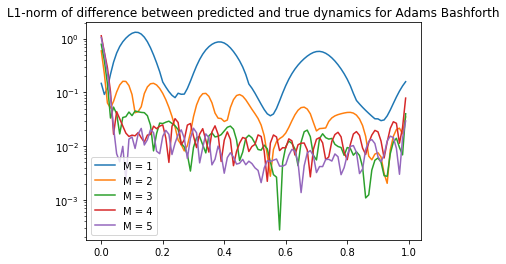

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open('errors.pkl', 'rb') as file:
    errors = pickle.load(file)

grid_points = np.arange(0, 1, 0.01)

scheme = 'Adams Bashforth'
plt.title('L1-norm of difference between predicted and true dynamics for ' + scheme)
plt.yscale('log')

plt.plot(grid_points, errors['AB1'], label='M = 1')
plt.plot(grid_points, errors['AB2'], label='M = 2')
plt.plot(grid_points, errors['AB3'], label='M = 3')
plt.plot(grid_points, errors['AB4'], label='M = 4')
plt.plot(grid_points, errors['AB5'], label='M = 5')
plt.legend()


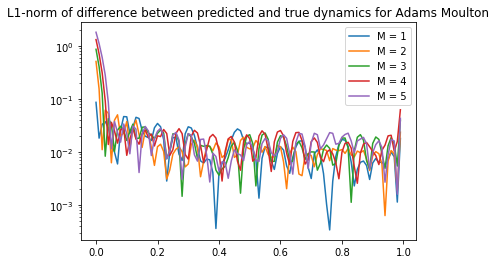

In [12]:
scheme = 'Adams Moulton'
plt.title('L1-norm of difference between predicted and true dynamics for ' + scheme)
plt.yscale('log')

plt.plot(grid_points, errors['AM1'], label='M = 1')
plt.plot(grid_points, errors['AM2'], label='M = 2')
plt.plot(grid_points, errors['AM3'], label='M = 3')
plt.plot(grid_points, errors['AM4'], label='M = 4')
plt.plot(grid_points, errors['AM5'], label='M = 5')
plt.legend()

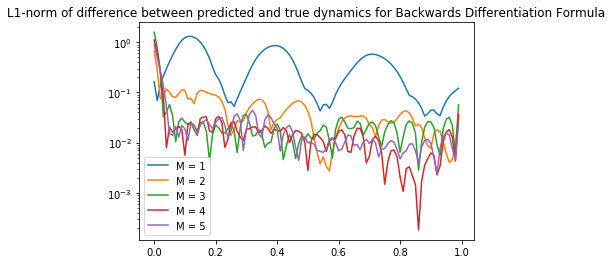

In [13]:
scheme = 'Backwards Differentiation Formula'
plt.title('L1-norm of difference between predicted and true dynamics for ' + scheme)
plt.yscale('log')
plt.plot(grid_points, errors['BDF1'], label='M = 1')
plt.plot(grid_points, errors['BDF2'], label='M = 2')
plt.plot(grid_points, errors['BDF3'], label='M = 3')
plt.plot(grid_points, errors['BDF4'], label='M = 4')
plt.plot(grid_points, errors['BDF5'], label='M = 5')
plt.legend()

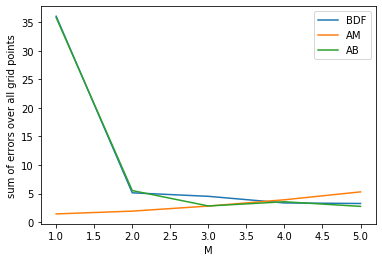

In [6]:
# make sure all errors are greater than zero

bdf = [np.sum(errors['BDF' + str(i)]) for i in range(1, 6)]
ab = [np.sum(errors['AB' + str(i)]) for i in range(1, 6)]
am = [np.sum(errors['AM' + str(i)]) for i in range(1, 6)]

plt.plot(range(1, 6), bdf, label='BDF')
plt.plot(range(1, 6), am, label='AM')
plt.plot(range(1, 6), ab, label='AB')
plt.xlabel('M')
plt.ylabel('sum of errors over all grid points')
plt.legend()

# 4. Recontruction of long-time dynamics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

time_points = np.arange(0,25,0.01)
with open('test_pred.npy', 'rb') as file:
    test_pred = np.load(file)

def f(x,t):
    """
    Return the derivatives (RHS of the ODE)
    This is a linear system with the form f = A x
    Args:
    x -- a 2 x 1 vector of measurements
    """
    A = np.array([[-0.1, 2], [-2,-0.1]]) # 2 x 2

    return np.ravel(np.matmul(A,x.reshape(-1, 1)**3))

# create time points
time_points = np.arange(0,25,0.01)

# specify initial conditions
x0 = np.array([2,0])

simulated_x = odeint(f, x0, time_points)

Text(0.5, 1.0, 'Trajectories of 2D Cubic Harmonic Oscillator')

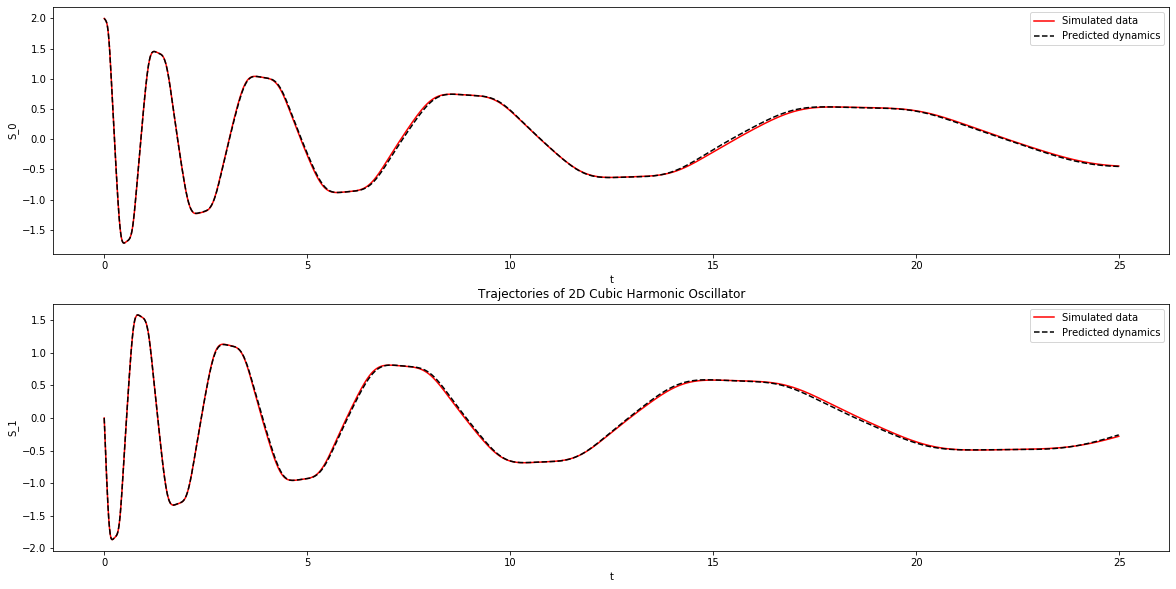

In [3]:

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, simulated_x[:, species], 'r-', label='Simulated data')
    plt.plot(time_points, test_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Cubic Harmonic Oscillator')

Text(0.5, 1.0, 'Phase plane of 2D Cubic Harmonic Oscillator')

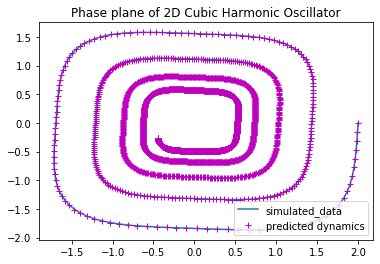

In [4]:
# Phase plane

plt.plot(simulated_x[:,0], simulated_x[:,1], label='simulated_data')
plt.legend()
plt.plot(test_pred[:,0], test_pred[:,1], 'm+', label='predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Cubic Harmonic Oscillator')